# Import Libraries

In [1]:
pwd

'/content'

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
from model import *
from utils import *

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 405933521.23it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 104517423.49it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 172534961.50it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23577387.09it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


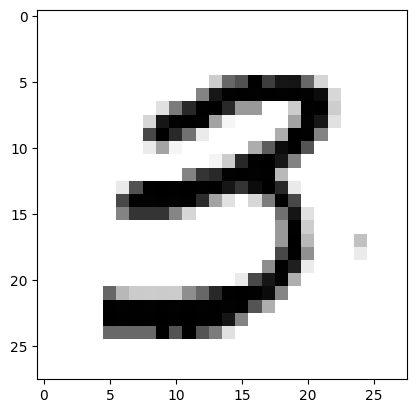

In [11]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_set = train_data.train_data
train_set = train_data.transform(train_set.numpy())

print('[Train]')
print(' - Numpy Shape:', train_data.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_data.train_data.size())
print(' - min:', torch.min(train_set))
print(' - max:', torch.max(train_set))
print(' - mean:', torch.mean(train_set))
print(' - std:', torch.std(train_set))
print(' - var:', torch.var(train_set))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


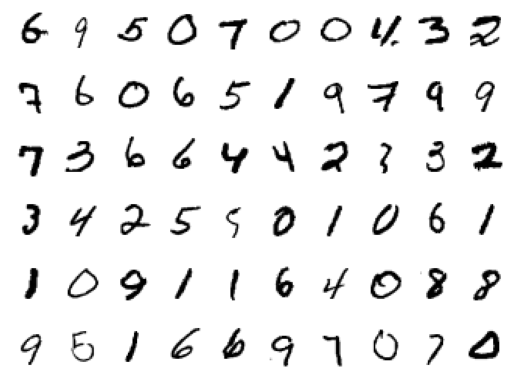

In [12]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

In [4]:
from model import Net2

# Model Params

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_summary(Net2, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,432
              ReLU-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
            Conv2d-6           [-1, 16, 10, 10]           9,216
              ReLU-7           [-1, 16, 10, 10]               0
            Conv2d-8           [-1, 32, 10, 10]             512
              ReLU-9           [-1, 32, 10, 10]               0
        MaxPool2d-10             [-1, 32, 5, 5]               0
           Conv2d-11             [-1, 64, 3, 3]          18,432
             ReLU-12             [-1, 64, 3, 3]               0
           Conv2d-13             [-1, 16, 3, 3]           9,216
             ReLU-14             [-1, 1

# Training and Testing


In [15]:
train_losses_t = []
test_losses_t = []
train_acc_t = []
test_acc_t = []

# Let's Train and test our model

In [16]:
model =  Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch)
    train_losses_t += train_losses
    train_acc_t.append(train_acc)
    test_losses, test_acc = test(model, device, test_loader)
    test_losses_t += test_losses
    test_acc_t.append(test_acc)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.06645823270082474 Batch_id=468 Accuracy=70.64: 100%|██████████| 469/469 [00:18<00:00, 25.55it/s]



Test set: Average loss: 0.1239, Accuracy: 9598/10000 (95.98%)

EPOCH: 1


Loss=0.09179524332284927 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:18<00:00, 24.92it/s]



Test set: Average loss: 0.0733, Accuracy: 9753/10000 (97.53%)

EPOCH: 2


Loss=0.10922381281852722 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:18<00:00, 24.91it/s]



Test set: Average loss: 0.0489, Accuracy: 9830/10000 (98.30%)

EPOCH: 3


Loss=0.029394149780273438 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]



Test set: Average loss: 0.0366, Accuracy: 9886/10000 (98.86%)

EPOCH: 4


Loss=0.10297716408967972 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:17<00:00, 26.64it/s]



Test set: Average loss: 0.0388, Accuracy: 9875/10000 (98.75%)

EPOCH: 5


Loss=0.06051810085773468 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:16<00:00, 27.65it/s]



Test set: Average loss: 0.0343, Accuracy: 9882/10000 (98.82%)

EPOCH: 6


Loss=0.005875181872397661 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 26.74it/s]



Test set: Average loss: 0.0431, Accuracy: 9854/10000 (98.54%)

EPOCH: 7


Loss=0.018159668892621994 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:16<00:00, 27.68it/s]



Test set: Average loss: 0.0290, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.015019101090729237 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 27.40it/s]



Test set: Average loss: 0.0304, Accuracy: 9892/10000 (98.92%)

EPOCH: 9


Loss=0.05271332338452339 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:17<00:00, 26.15it/s]



Test set: Average loss: 0.0330, Accuracy: 9889/10000 (98.89%)

EPOCH: 10


Loss=0.0019849969539791346 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:16<00:00, 28.26it/s]



Test set: Average loss: 0.0295, Accuracy: 9906/10000 (99.06%)

EPOCH: 11


Loss=0.002657027216628194 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:17<00:00, 27.44it/s]



Test set: Average loss: 0.0323, Accuracy: 9896/10000 (98.96%)

EPOCH: 12


Loss=0.0058790273033082485 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:16<00:00, 28.19it/s]



Test set: Average loss: 0.0405, Accuracy: 9880/10000 (98.80%)

EPOCH: 13


Loss=0.0015599485486745834 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]



Test set: Average loss: 0.0292, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=0.00835974421352148 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]



Test set: Average loss: 0.0344, Accuracy: 9903/10000 (99.03%)



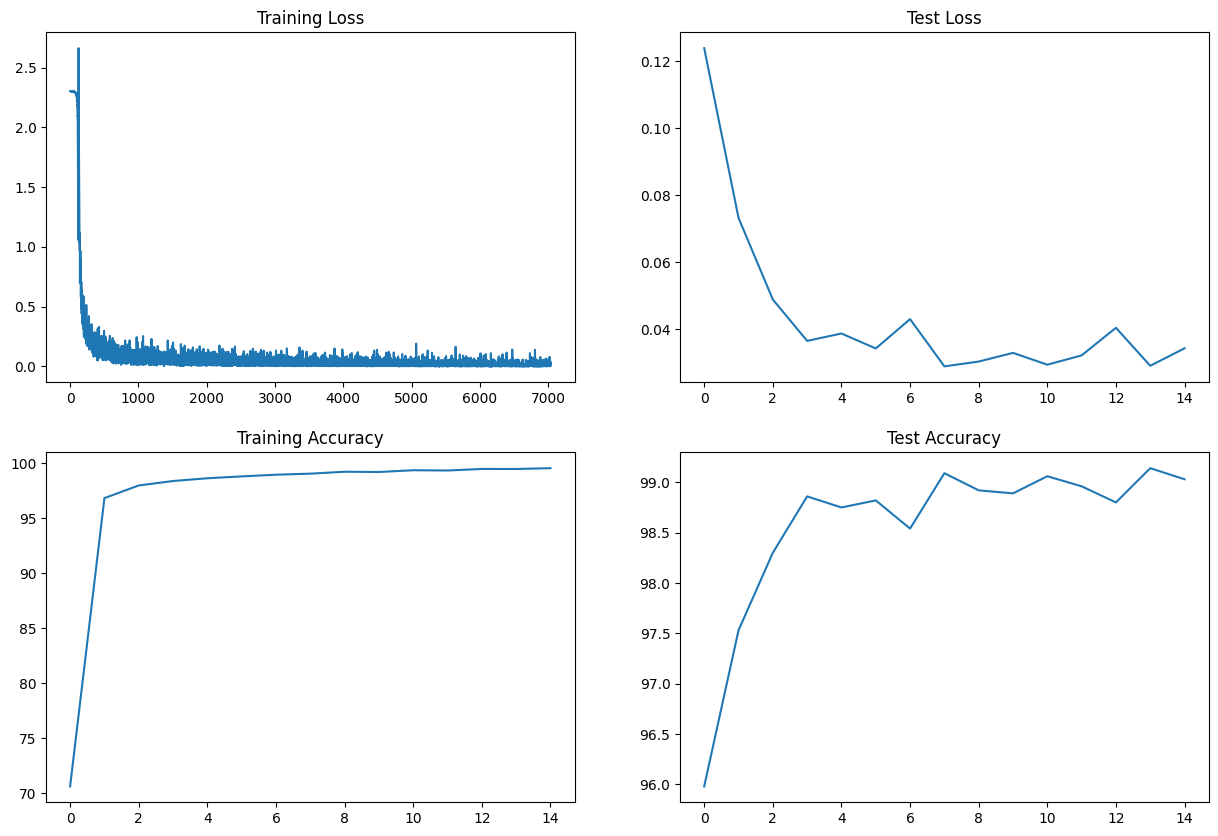

In [17]:
plot_loss_acc(train_losses_t, train_acc_t, test_losses_t, test_acc_t)